In [1]:
# linear modelling functions
#HENRY AND JUN
#MERGED KAMMEN + COOLCLIMAE
!pip install ipynb
import ipynb.fs.full.general_model_pipeline_vl as gmp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

SyntaxError: invalid syntax (general_model_pipeline_vl.ipynb, line 35)

#### Splitting the dataset 

These models will use 80% training data and 20% of testing data.

In [ ]:
rs = 100
np.random.seed(100)

# frac train
train_size = 0.8

In [ ]:
df1 = pd.read_csv('../../data/new-cleaned-household-data.csv')
df1['airflights'] = df1['input_footprint_transportation_airshort']+df1['input_footprint_transportation_airmedium']+df1['input_footprint_transportation_airlong']
df = df1[['input_income', 'input_footprint_transportation_num_vehicles', 'input_footprint_transportation_mpg1', 'input_footprint_transportation_miles1', 'input_footprint_transportation_fuel1', 'airflights', 'input_footprint_housing_electricity_dollars', 'input_footprint_housing_squarefeet', 'input_footprint_shopping_goods_clothing', 'result_grand_total']]

df.reset_index(drop = False, inplace = True)

train_data = df.sample(frac=train_size)
test_data = df[df['index'].apply(lambda x: x not in train_data['index'].values)]

train_data.drop(columns='index', inplace=True)
test_data.drop(columns='index', inplace=True)
train_data.shape, test_data.shape



## Forecasting and Prediction Modeling (25 points)

This section is where the rubber meets the road.  In it you must:
1. Explore at least 3 prediction modeling approaches for each prediction question, ranging from the simple (e.g. linear regression, KNN) to the complex (e.g. SVM, random forests, Lasso).  
2. Motivate all your modeling decisions.  This includes parameter choices (e.g., how many folds in k-fold cross validation, what time window you use for averaging your data) as well as model form (e.g., If you use regression trees, why?  If you include nonlinear features in a regression model, why?). 
1. Carefully describe your cross validation and model selection process.  You should partition your data into training and testing data sets.  The training data set is what you use for cross-validation (i.e. you sample from within it to create folds, etc.).  The testing data set is held to the very end of your efforts, and used to compare qualitatively different models (e.g. OLS vs random forests).
4. Very carefully document your workflow.  We will be reading a lot of projects, so we need you to explain each basic step in your analysis.  
5. Seek opportunities to write functions allow you to avoid doing things over and over, and that make your code more succinct and readable. 

### Model 1: Simple Linear Regression

We will begin by looking at a simple linear regression model.

In [2]:

X_train, X_val, y_train, y_val = gmp.preprocess_data(train_data, 'result_grand_total')

lm = LinearRegression()
lin_model = gmp.run_model(X_train, X_val, y_train, y_val, lm, diagnostics = True)

NameError: name 'gmp' is not defined

This model gave a Test MSE of 1.4711 and R^2 value of 0.9959, so this is a very good model.

### Model 2: Ridge Regression

In [49]:
X_train, X_val, y_val, y_val = gmp.preprocess_data(train_data, 'result_grand_total', standardize = True)

alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, alphas)

Splitting data...
optimal alpha: 0.001
Test MSE with cross-validated RidgeCV: 5.115673947302171
[R^2: 0.9557117979687159]


0.001

This gave an optimal alpha value of 0.1. We will zoom in around that value to see if there is an even optimal valu of alpha and then see the new test MSE. 

In [52]:
new_alphas = np.arange(0,0.001,0.0001)
gmp.linreg_kfold_cv(RidgeCV, X_train, X_val, y_train, y_val, new_alphas)

optimal alpha: 0.0001
Test MSE with cross-validated RidgeCV: 5.115668257010882
[R^2: 0.9557118472315839]


0.0001

Fitting Model...
[Train MSE: 3.9345]
[Train R^2: 0.9557118472315839]
[Test MSE: 5.1157]
[Test R^2: 0.9557118472315839]
----FINISHED----


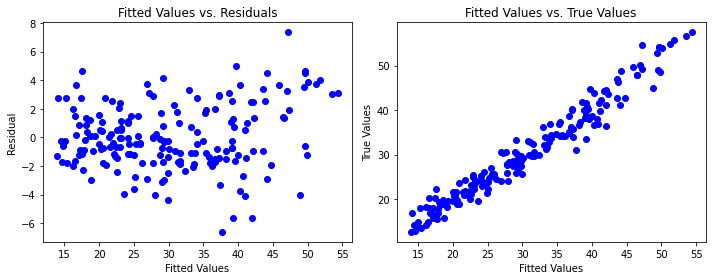

In [53]:
ridge_model = Ridge(alpha=0.0001)
ridge_model = gmp.run_model(X_train, X_val, y_train, y_val, ridge_model, diagnostics=True)

what does this tlel me


### Model 3: Lasso Regression

In [ ]:
X_train, X_val, y_val, y_val = gmp.preprocess_data(df, 'result_grand_total',)

alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, alphas)

In [ ]:
new_alphas_lasso = np.arange(0,0.01,0.0001)
gmp.linreg_kfold_cv(LassoCV, X_train, X_val, y_train, y_val, new_alphas_lasso)

In [ ]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(df, 'result_grand_total', standardize = True)

lasso_model = Lasso(alpha=0.0002)
lasso_model = gmp.run_model(X_train, X_val, y_train, y_val, lasso_model, diagnostics=True)

## Model 4: Decision Tree

Why i did decision trees

In [47]:
param_dist = {'max_leaf_nodes': np.arange(2, 20),
              'max_features': np.arange(2, 10),
              'max_depth': np.arange(2,10)}

tree = DecisionTreeRegressor(random_state = 100, max_depth = 4, max_features=5, max_leaf_nodes=10)
gmp.tree_kfold_cv(tree, param_dist, X_train, y_train, n_iter=1000, random_state = 100)

0.9173525999266186
{'max_leaf_nodes': 19, 'max_features': 7, 'max_depth': 7}


In [ ]:
X_train, X_val, y_train, y_val = gmp.preprocess_data(df, 'result_grand_total', standardize = False)

tree_model = DecisionTreeRegressor(random_state=100, max_leaf_nodes = 19,
                                   max_depth=8, max_features = 10)
tree_model = gmp.run_model(X_train, X_val, y_train, y_val, tree_model, diagnostics=True)

What does this mean

## Interpretation and Conclusions (20 points)
In this section you must relate your modeling and forecasting results to your original prediction question.  You must:
1. Address a resource allocation question.  What do the answers mean? What advice would you give a decision maker on the basis of your results?  How might they allocate their resources differently with the results of your model?  Why should the reader care about your results?
2. Discuss caveats and / or reasons your results might be flawed.  No model is perfect, and understanding a model's imperfections is extremely important for the purpose of knowing how to interpret your results.  Often, we know the model output is wrong but we can assign a direction for its bias.  This helps to understand whether or not your answers are conservative.  

Shoot for 500-1000 words for this section.

goal make